In [2]:
import pandas as pd

data = pd.read_csv(r'C:\Desktop\BERT Finetuning\dataset\twitter_multi_class_sentiment.csv')
data.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### `Sanity check`

In [6]:
pd.DataFrame(pd.concat([data.isna().sum(), data.isna().mean()*100], axis=1), columns=['Count', 'Percentage'])

,Count,Percentage
text,NaN,NaN
label,NaN,NaN
label_name,NaN,NaN


In [7]:
data['label'].value_counts()

label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64

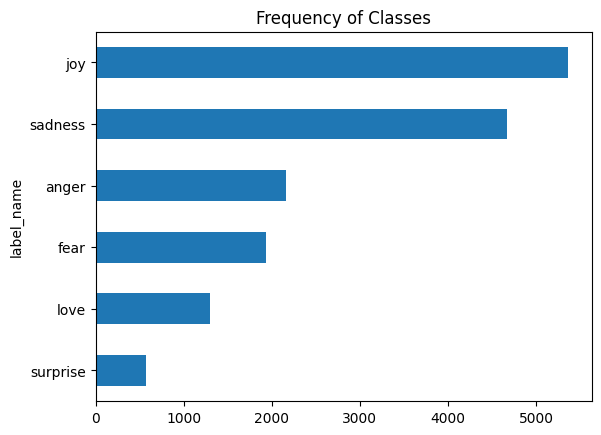

In [9]:
import matplotlib.pyplot as plt

label_counts = data['label_name'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

<Axes: title={'center': 'Words per Tweet'}, xlabel='label_name'>

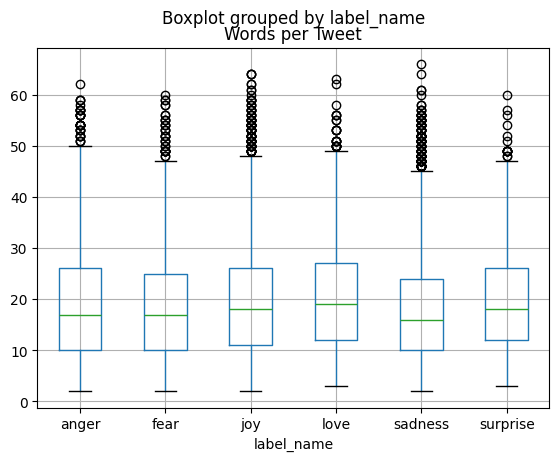

In [10]:
data['Words per Tweet'] = data['text'].str.split().apply(len)
data.boxplot("Words per Tweet", by="label_name")

### `Text to Token conversion`

In [13]:
from transformers import AutoTokenizer

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, stratify=data['label_name'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label_name'])

train.shape, test.shape, validation.shape

((11200, 4), (3200, 4), (1600, 4))

In [14]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {'train':Dataset.from_pandas(train, preserve_index=False),
     'test':Dataset.from_pandas(test, preserve_index=False),
     'validation': Dataset.from_pandas(validation, preserve_index=False)
     }
     
)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 1600
    })
})

In [15]:
dataset['train'][0], dataset['train'][1]

({'text': 'i said i feel like im on the verge of very messy',
  'label': 0,
  'label_name': 'sadness',
  'Words per Tweet': 12},
 {'text': 'i feel good about the choices i made in terms of our readings',
  'label': 1,
  'label_name': 'joy',
  'Words per Tweet': 13})

In [16]:
def tokenize(batch):
    temp = tokenizer(batch['text'], padding=True, truncation=True)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 1045, 2056, 1045, 2514, 2066, 10047, 2006, 1996, 16079, 1997, 2200, 18307, 102, 0], [101, 1045, 2514, 2204, 2055, 1996, 9804, 1045, 2081, 1999, 3408, 1997, 2256, 15324, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [17]:
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map: 100%|██████████| 1600/1600 [00:00<00:00, 17432.59 examples/s]


In [18]:
# label2id, id2label
label2id = {x['label_name']:x['label'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

label2id, id2label

({'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5},
 {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'})

### `Model Building`

In [19]:
from transformers import AutoModel 
import torch

In [20]:
model = AutoModel.from_pretrained(model_ckpt)

In [21]:
model.config.id2label
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

### `Finetuning BERT`

In [22]:
from transformers import AutoModelForSequenceClassification, AutoConfig

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

### `Training Arguments`

In [25]:
from transformers import TrainingArguments

batch_size = 64
training_dir = "bert_base_train_dir"

training_args = TrainingArguments( output_dir=training_dir,
                                  overwrite_output_dir = True,
                                  num_train_epochs = 2,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  eval_strategy = 'epoch',
                                  disable_tqdm = False
)

### `Compute metrics`

In [26]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

### `Build Model and Trainer`

In [27]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset = emotion_encoded['train'],
                  eval_dataset = emotion_encoded['validation'],
                  tokenizer = tokenizer)

C:\Users\thara\AppData\Local\Temp\ipykernel_26688\1591179924.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


In [28]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.511045,0.820000,0.791870
2,No log,0.284588,0.909375,0.908822


TrainOutput(global_step=350, training_loss=0.7325510951450893, metrics={'train_runtime': 1836.9329, 'train_samples_per_second': 12.194, 'train_steps_per_second': 0.191, 'total_flos': 897898722739200.0, 'train_loss': 0.7325510951450893, 'epoch': 2.0})

### `Model Evaluation`

In [29]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

{'test_loss': 0.3136752247810364,
 'test_accuracy': 0.898125,
 'test_f1': 0.8969712501924012,
 'test_runtime': 68.0943,
 'test_samples_per_second': 46.994,
 'test_steps_per_second': 0.734}

In [31]:
import numpy as np
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       933
           1       0.91      0.93      0.92      1072
           2       0.80      0.75      0.78       261
           3       0.88      0.92      0.90       432
           4       0.88      0.87      0.87       387
           5       0.86      0.64      0.74       115

    accuracy                           0.90      3200
   macro avg       0.88      0.84      0.86      3200
weighted avg       0.90      0.90      0.90      3200



In [33]:
label2id

{'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

### `Plot confusion Matrix`

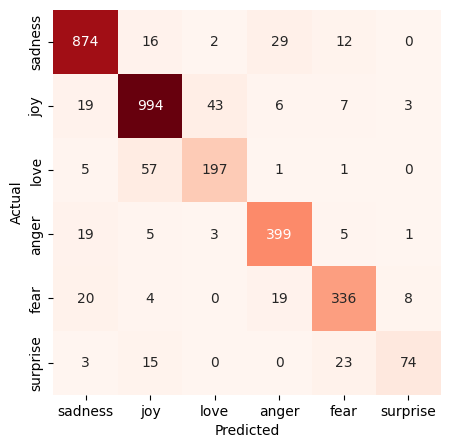

In [34]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [36]:
import os
os.makedirs("model", exist_ok=True)
trainer.save_model("model/bert-base-uncased-sentiment-model")

In [39]:
from transformers import pipeline

classifier = pipeline('text-classification', model= r'C:\Desktop\BERT Finetuning\code\model\bert-base-uncased-sentiment-model')

classifier(['hello, how are you?', "love you", "i am feeling low"])

Device set to use cuda:0


[{'label': 'joy', 'score': 0.7464912533760071},
 {'label': 'love', 'score': 0.39760807156562805},
 {'label': 'sadness', 'score': 0.9547477960586548}]